# Mouse skull 3D atlas v00
In this notebook we run registration for mouse data with skull, MD816.  Here we just look at 3D datasets.


Note atlas MRI is 50,50,50 micron

We will map to CCF which is 50,50,50.



In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os


# for debugging only
import imp
imp.reload(emlddmm)

KeyboardInterrupt: 

In [ ]:
atlas_name = 'C:\\Users\\BGAdmin\\data\\MD816/HR_NIHxCSHL_50um_14T_M1_masked.vtk'
target_name = 'C:\\Users\\BGAdmin\\data\\Allen_Atlas_vtk/average_template_50.vtk'


config_file = 'configMD816_MR_to_CCF.json'
output_dir = 'MD816_test_CCF_00/'

In [ ]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

Found extension .vtk
[50. 50. 50.]


Text(0.5, 0.98, 'Atlas image')

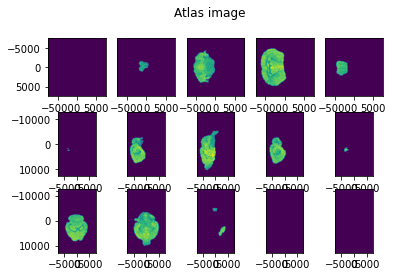

In [ ]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')


Text(0.5, 1.0, 'Atlas pixel intensities')

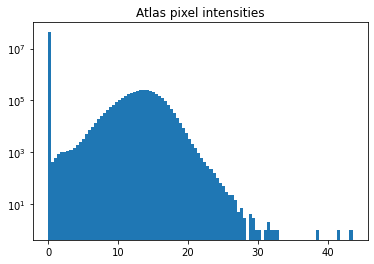

In [ ]:
fig,ax = plt.subplots()
ax.hist(I.ravel(),bins=100,log=True)
ax.set_title('Atlas pixel intensities')

In [ ]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[100.0, 100.0, 100.0]


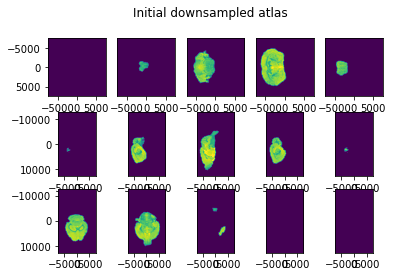

In [ ]:
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Initial downsampled atlas')
fig[0].canvas.draw()

Found extension .vtk
[50. 50. 50.]


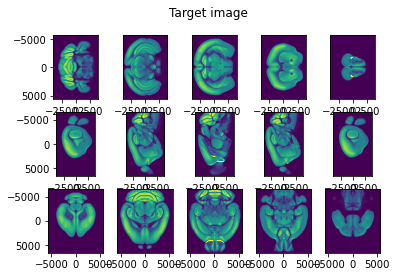

In [ ]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()
W0 = np.ones_like(J[0])


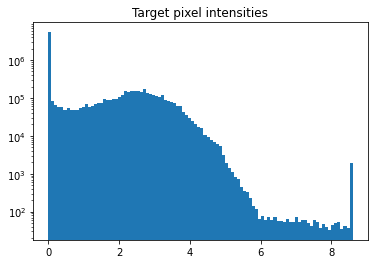

In [ ]:
fig,ax = plt.subplots()
ax.hist(J.ravel(),bins=100,log=True)
ax.set_title('Target pixel intensities')
fig.canvas.draw()

In [ ]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
print(dJ)
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

[100.0, 100.0, 100.0]


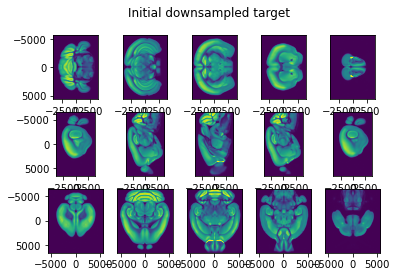

In [ ]:
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Initial downsampled target')
fig[0].canvas.draw()


[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


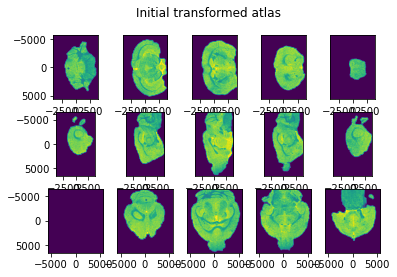

In [ ]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)    
print(A)

# for simplicity I will add a translation manually 
A[:3,-1] = [-4000,100,4000]
config['A'] = A

# this affine matrix should be 4x4, but it may be 1x4x4
while A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')
fig[0].canvas.draw()


In [ ]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

Found 2 scales


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output[-1])

cpu
output dir is MD816_test_CCF_00/qc/
J shape:  torch.Size([1, 132, 114, 80])
AphiI shape:  torch.Size([1, 132, 114, 80])
Hausdorff distance:  (1146.1861308297334, 51883, 51609)


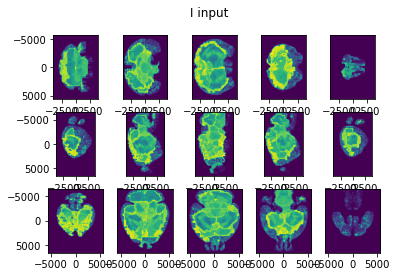

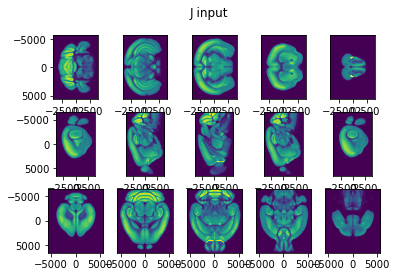

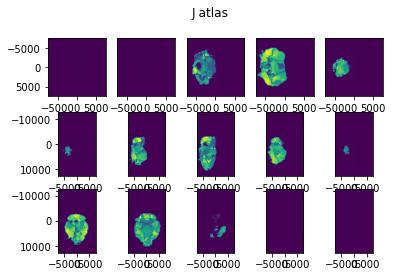

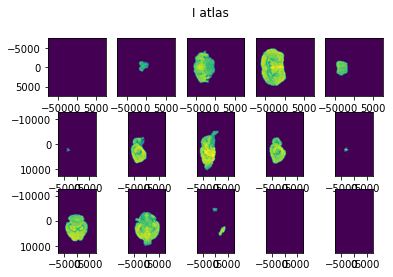

In [ ]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output[-1],xI,I,xJ,J,)

In [ ]:
# apply forward transform (target image to atlas)
imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

starting to compose sequence with transforms MD816_test_CCF_00/


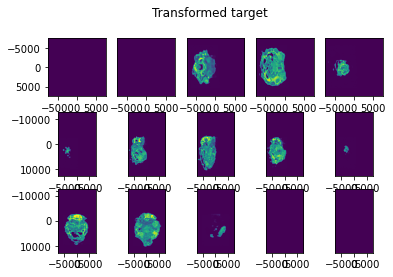

In [ ]:
fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Transformed target')
fig[0].canvas.draw()

In [ ]:
# apply backward transform (atlas images to target)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin,direction='b')
It = emlddmm.apply_transform_float(xI,I,Xout)

starting to compose sequence with transforms MD816_test_CCF_00/


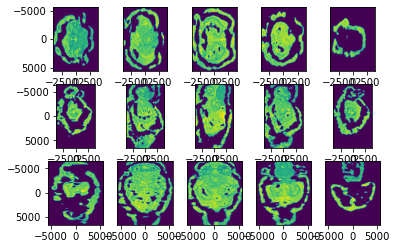

In [ ]:
fig = emlddmm.draw(It,xJ)
fig[0].canvas.draw()


In [ ]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [ ]:
# write transformed images, these are at low res
imp.reload(emlddmm)
ext = '.vtk'
if ext[0] != '.': ext = '.' + ext
imp.reload(emlddmm)
emlddmm.write_data(os.path.join(atlas_output_dir,'target_to_atlas'+ext),xI,Jt,'target_to_atlas')

emlddmm.write_data(os.path.join(target_output_dir,'atlas_to_target'+ext),xI,It,'atlas_to_target')

Found extension .vtk
Found extension .vtk


Found extension .vtk
[50. 50. 50.]
Found extension .vtk
[50. 50. 50.]
starting to compose sequence with transforms MD816_test_CCF_00/
Found extension .vtk


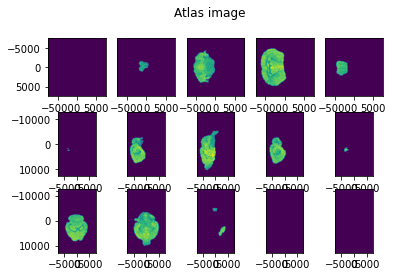

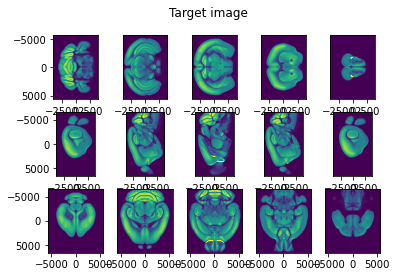

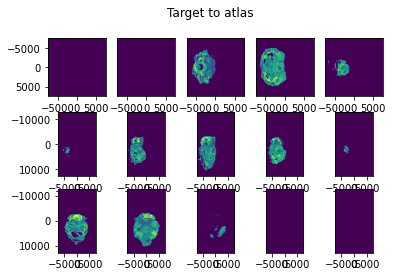

In [ ]:
# reload atlas at full res 
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_data(atlas_name)
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')



# transform target images at full res
xJ,J,title,names = emlddmm.read_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
xJ = [x for x in xJ]
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
fig[0].canvas.draw()

Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

fig = emlddmm.draw(Jt,xI)
fig[0].suptitle('Target to atlas')
fig[0].canvas.draw()

# write out
outname = os.path.splitext(os.path.split(target_name)[1])[0]
outname = os.path.join(atlas_output_dir,outname+ext)
emlddmm.write_data(outname,xI,Jt,'target_to_atlas')